<h1 style="font-size:40px;">Kaggle mini project</h1>

**Cancer detection using CNN for the Week 3 of the course Introduction to Deep Learning in Coursera.**

<p style="text-align: justify;">
From the kaggle page, we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.
In this dataset, it is provided a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
</p>


In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from skimage import io
import torch
import matplotlib.pyplot as plt
import torchvision
import os
from PIL import Image
import random
import numpy as np

**Basic EDA** 

In this section, it will be performed a basic exploratory data analysis to obtain insight of the number of samples, sizes, mean values, or any cleaning procedure relevant for the data. It will be inspected, visualized and cleaned if necessary.

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data = pd.read_csv(csv_file)
        print('Data has length of: ', len(self.data))
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]  # Image ID from CSV
        label = self.data.iloc[idx, 1]   # Class label
        img_path = f"{self.root_dir}/{img_id}.tif"
        
        # Load the image as a matrix (NumPy array)
        image = io.imread(img_path)  # Loads image as a NumPy array
        image = torch.tensor(image, dtype=torch.float32)  # Convert to PyTorch tensor
        
        # Optionally, normalize or adjust the shape if needed
        if len(image.shape) == 2:  # If the image is grayscale
            image = image.unsqueeze(0)  # Add a channel dimension
        elif len(image.shape) == 3 and image.shape[2] == 3:  # If the image is RGB
            image = image.permute(2, 0, 1)  # Change to [C, H, W] format
        
        return image, label

# Use the DataLoader as usual
dataset = ImageDataset(csv_file='D:/PythonCourse/CancerDetection/data/train_labels.csv', root_dir='D:/PythonCourse/CancerDetection/data/train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Data has length of:  220025


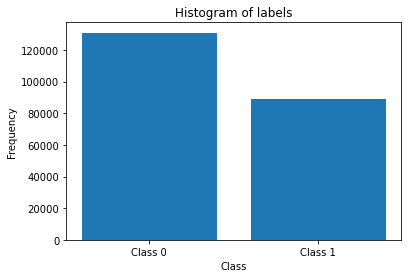

In [3]:
# Count the occurrences of each class
class_counts = dataset.data['label'].value_counts()
# Create a bar plot
plt.bar(class_counts.index, class_counts.values)
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of labels')
plt.show()

In [4]:
image_shapes = []
image_dir = 'D:/PythonCourse/CancerDetection/data/train/'
res = random.sample(range(0, len(dataset.data)), 50)
for index in res:
    img_name = dataset.data['id'][index]+'.tif'
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    image_shapes.append(img.size)  # Returns (width, height)

# Convert to DataFrame for analysis
image_shapes_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(image_shapes_df.describe())  # Summary statistics

       Width  Height
count   50.0    50.0
mean    96.0    96.0
std      0.0     0.0
min     96.0    96.0
25%     96.0    96.0
50%     96.0    96.0
75%     96.0    96.0
max     96.0    96.0


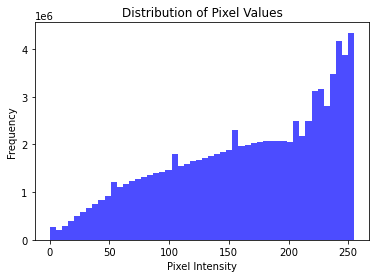

In [5]:
data_iter = iter(dataloader)
pixel_values = []
# Loop through the data to extract pixel values
for i in range(0,100):
    images, labels = next(data_iter)
    # Convert image tensors to numpy arrays and collect pixel values
    pixel_values.append(images.cpu().numpy().ravel())  # Flatten the pixel values
# Concatenate all pixel values into a single array
pixel_values = np.concatenate(pixel_values)
# Plot histogram of pixel values
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Pixel Values")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

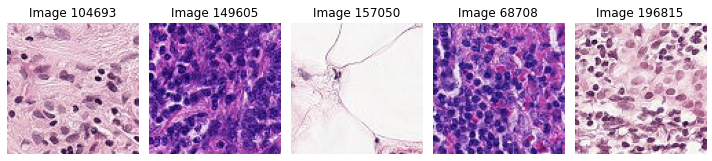

In [11]:
image_dir = 'D:/PythonCourse/CancerDetection/data/train/'
res = random.sample(range(0, len(dataset.data)), 5)
# Figure to display the images
plt.figure(figsize=(10, 10))
# Loop through the sampled indices and display each image
for i, index in enumerate(res):
    img_name = dataset.data['id'][index] + '.tif'  
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)  # Open the image using PIL
    # Display the image in a subplot
    plt.subplot(1, 5, i + 1)  # 1 row, 5 columns, and i+1 means the ith image
    plt.imshow(img)
    plt.title(f"Image {index}")
    plt.axis('off') 
plt.tight_layout()
plt.show()

**Model Architecture**
<p style="text-align: justify;">
Since this is a binary classification problem on a dataset that contains relatively small images (96x96), it can be explored a simple CNN architecture and then explore more complex networks as we get insights into the performance achieved by network.

A simple CNN of 3 convolution layers where each convolution is followed by a pooling layer, and a fully connected layer for the classification. The first activation function considered is the ReLU for its proven functionality with CNNs.
</p>


In [4]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Subset


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max pooling
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.fc1 = nn.Linear(64 * 12 * 12, 512) 
        self.fc2 = nn.Linear(512, 2)  # Binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform  # Optional transform argument
        # print('Data has length of: ', len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]  # Image ID from CSV
        label = self.data.iloc[idx, 1]   # Class label
        img_path = f"{self.root_dir}/{img_id}.tif"
        
        # Load the image as a matrix (NumPy array)
        image = io.imread(img_path)  # Loads image as a NumPy array
        image = torch.tensor(image, dtype=torch.float32)  # Convert to PyTorch tensor
        
        # Handle channel dimension if necessary
        if len(image.shape) == 2:  # If the image is grayscale
            image = image.unsqueeze(0)  # Add a channel dimension
        elif len(image.shape) == 3 and image.shape[2] == 3:  # If the image is RGB
            image = image.permute(2, 0, 1)  # Change to [C, H, W] format

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

dataset = ImageDataset(csv_file='D:/PythonCourse/CancerDetection/data/train_labels.csv', 
                       root_dir='D:/PythonCourse/CancerDetection/data/train')
train_size = int(0.9 * len(dataset))  # 60% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# Use random_split to create training and validation datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

subset_size = int(0.7 * train_size)  # 50% of the dataset
indices = np.random.choice(len(dataset), size=subset_size, replace=False)  # Randomly select indices
subset_dataset = Subset(dataset, indices)

subset_size_dummy = int(0.1 * train_size)  # 10% of the dataset
indices_dummy = np.random.choice(len(dataset), size=subset_size_dummy, replace=False)  # Randomly select indices
subset_dataset_dummy = Subset(dataset, indices_dummy)


# Create DataLoaders for each subset
train_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
dummy_train = DataLoader(subset_dataset_dummy, batch_size=32, shuffle=True)

In [7]:
# Hyperparameters
def training_simpleCNN(model, num_epochs=3, learning_rate=0.001, file_name='simple_cnn.pth'):   
    batch_size = 32  # Size of each batch
    # Initialize the model, loss function, and optimizer
    criterion = nn.CrossEntropyLoss()  # For binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)    
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0  
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
    
            # Zero the parameter gradients
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            if (i + 1) % 1000 == 0:  # Print every 1000 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0
    
    # Optionally save the trained model
    torch.save(model.state_dict(), file_name)
    print("Training Finished!")


In [8]:
def calculate_acc(model):
    correct = 0
    total = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            model_vgg = model.to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # Get predictions: The output is the raw scores (logits), and torch.max returns the class with the highest score.
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            # Compare predictions with true labels
            total += labels.size(0)  # Count total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions
    # Calculate accuracy
    return 100 * correct / total

    

In [ ]:
# lr_exp = [0.001, 0.003, 0.006, 0.01]
# models = []
# for i, lr in enumerate(lr_exp):
#     models.append(SimpleCNN())
#     filename = 'simple_cnn'+str(i)+'.pth'
#     training_simpleCNN(model=models[i], num_epochs=5, learning_rate=lr,file_name=filename)
#     print('Model ', i,' finished')

In [26]:
acc = []
for i, model in enumerate(models):
    acc.append(calculate_acc(model))
    print('The accuracy achieved by model', i,'is: ', acc[i])


The accuracy achieved by model 0 is:  86.97904831159387
The accuracy achieved by model 1 is:  80.2208789710494
The accuracy achieved by model 2 is:  59.41008044357588
The accuracy achieved by model 3 is:  59.41008044357588


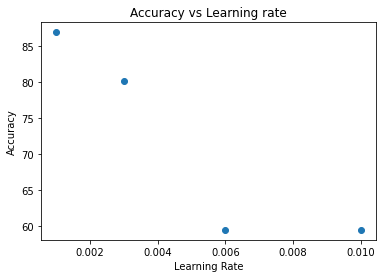

In [33]:
plt.scatter(lr_exp,acc)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning rate')
plt.show()

Model training started: 3:10 pm and finished: 4:30 pm
It can be observed that increasing the learning rate tends to decrease the accuracy, so for the following attempts, the approach will be taken with small learning rate values (around 0.001). This simple CNN with 3 convolutional layers, followed by max pooling layer each and 3 fully connected layers for inference provided results around 87% in the validation subset. In order to avoid excessive computing, a subtle more complex network will be explored.

From the set of proven architectures, it can be noted that VGG16 architecture has been proven to yield good results, although not state-of-the-art they might be enough for this application. It will be implemented in a simpler architecture with less convolutional blocks.





In [24]:
class CustomVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 96x96 -> 96x96
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 96x96 -> 96x96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)         # 96x96 -> 48x48
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 48x48 -> 48x48
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 48x48 -> 48x48
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)         # 48x48 -> 24x24
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 24x24 -> 24x24
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 24x24 -> 24x24
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)         # 24x24 -> 12x12
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 12x12 -> 12x12
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),# 12x12 -> 12x12
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)         # 12x12 -> 6x6
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 512)            # Fully connected layer
        self.fc2 = nn.Linear(512, num_classes)            # Output layer for classification

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        
        x = x.view(x.size(0), -1)                        # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [36]:
model_vgg = CustomVGG()
filename = 'vgg_cnn.pth'
training_simpleCNN(model=model_vgg, num_epochs=5, learning_rate=0.001,file_name=filename)


Epoch [1/3], Step [1000/3095], Loss: 6.8289
Epoch [1/3], Step [2000/3095], Loss: 6.7583
Epoch [1/3], Step [3000/3095], Loss: 6.7563
Epoch [2/3], Step [1000/3095], Loss: 6.7602
Epoch [2/3], Step [2000/3095], Loss: 6.7457
Epoch [2/3], Step [3000/3095], Loss: 6.7551
Epoch [3/3], Step [1000/3095], Loss: 6.7579
Epoch [3/3], Step [2000/3095], Loss: 6.7501
Epoch [3/3], Step [3000/3095], Loss: 6.7559
Training Finished!


In [37]:
print(calculate_acc(model_vgg))

59.41008044357588


In [30]:
def training_momentum(model, learning_rate, file_name, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
    
    # Example training loop
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()   # Zero the gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()         # Backward pass
            optimizer.step()        # Update weights
            
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
    torch.save(model.state_dict(), file_name)
    print("Training Finished!")

In [31]:
model_vgg2 = CustomVGG()
filename = 'vgg_cnn5.pth'
training_momentum(model=model_vgg, learning_rate=0.0015,file_name=filename, epochs=5)

Epoch [1/5], Loss: 0.27952224016189575
Epoch [2/5], Loss: 0.02885548397898674
Epoch [3/5], Loss: 0.007423772942274809
Epoch [4/5], Loss: 0.001702458132058382
Epoch [5/5], Loss: 0.005344031844288111
Training Finished!


In [32]:
# Began Training: 06:33 pm began dummy
print(calculate_acc(model_vgg2))

40.60355406080989


In [11]:
class SimpleCNN_v2(nn.Module):
    def __init__(self):
        super(SimpleCNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after the first conv layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after the second conv layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after the third conv layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Additional layer
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after the fourth conv layer
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max pooling

        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjusted to match the flattened size after the extra layer
        self.dropout = nn.Dropout(0.5)  # Dropout to help with regularization
        self.fc2 = nn.Linear(512, 2)  # Binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Added the fourth conv layer

        x = x.view(-1, 128 * 6 * 6)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        return x


In [12]:
simple_cnn_v2 = SimpleCNN_v2()
training_simpleCNN(simple_cnn_v2, num_epochs=3, learning_rate=0.001, file_name='simple_cnn_v2.pth')

Epoch [1/3], Step [1000/4332], Loss: 4.6304
Epoch [1/3], Step [2000/4332], Loss: 3.9365
Epoch [1/3], Step [3000/4332], Loss: 3.6983
Epoch [1/3], Step [4000/4332], Loss: 3.4983
Epoch [2/3], Step [1000/4332], Loss: 3.3323
Epoch [2/3], Step [2000/4332], Loss: 3.1141
Epoch [2/3], Step [3000/4332], Loss: 3.0139
Epoch [2/3], Step [4000/4332], Loss: 2.8727
Epoch [3/3], Step [1000/4332], Loss: 2.7524
Epoch [3/3], Step [2000/4332], Loss: 2.5783
Epoch [3/3], Step [3000/4332], Loss: 2.5592
Epoch [3/3], Step [4000/4332], Loss: 2.4343
Training Finished!


In [13]:
print(calculate_acc(simple_cnn_v2))

91.15120665363814


Since the last attempt produced a better result, we can try using the complete training dataset for a few more epochs.

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [15]:
simple_cnn_v2_1 = SimpleCNN_v2()
training_simpleCNN(simple_cnn_v2_1, num_epochs=5, learning_rate=0.001, file_name='simple_cnn_v2_1.pth')

Epoch [1/5], Step [1000/6189], Loss: 4.5024
Epoch [1/5], Step [2000/6189], Loss: 3.8728
Epoch [1/5], Step [3000/6189], Loss: 3.6020
Epoch [1/5], Step [4000/6189], Loss: 3.5351
Epoch [1/5], Step [5000/6189], Loss: 3.3709
Epoch [1/5], Step [6000/6189], Loss: 3.1554
Epoch [2/5], Step [1000/6189], Loss: 2.9964
Epoch [2/5], Step [2000/6189], Loss: 2.7996
Epoch [2/5], Step [3000/6189], Loss: 2.7370
Epoch [2/5], Step [4000/6189], Loss: 2.5957
Epoch [2/5], Step [5000/6189], Loss: 2.5078
Epoch [2/5], Step [6000/6189], Loss: 2.3479
Epoch [3/5], Step [1000/6189], Loss: 2.2765
Epoch [3/5], Step [2000/6189], Loss: 2.2729
Epoch [3/5], Step [3000/6189], Loss: 2.1840
Epoch [3/5], Step [4000/6189], Loss: 2.1295
Epoch [3/5], Step [5000/6189], Loss: 2.1206
Epoch [3/5], Step [6000/6189], Loss: 2.0310
Epoch [4/5], Step [1000/6189], Loss: 1.9632
Epoch [4/5], Step [2000/6189], Loss: 1.8858
Epoch [4/5], Step [3000/6189], Loss: 1.9005
Epoch [4/5], Step [4000/6189], Loss: 1.8893
Epoch [4/5], Step [5000/6189], L

In [16]:
print(calculate_acc(simple_cnn_v2_1))

93.1736581375267


**Results and Analysis**

From the set of experiments ran using various CNN architectures, it could be obtained a result on the accuracy of 93.17% using a variation of the simple CNN proposed first, composed of 3 convolutional layers, followed by a pooling layer and 3 fully connected layers. The second strategy used to improve the performance of the network which used momentum and a scheduler for the learning rate did not yield an improvement. This lead to try to use a variation of the proven VGG architecture.

One of the aspects that could still be improved is the increase of epochs and some other approach in the architecture. The final version of the network used batch normalization and dropout to aid with the overfitting problem.
| Architecture | Validation acc | Epochs |
|----------|----------|----------|
| Simple CNN    | 87%  | 5  |
|Simple CNN improved|91.15%|3|
| Simple CNN improved   | 93.17%   | 5   |
|VGG| 59% | 5 |


**Conclusion**

A more complex architecture does not necessarily yield a better result, it might just increase the training time. It showed it is better to try simpler architectures and increase the complexity as needed. Trying strategies for the training is as important as choosing a good network, in my case, using momemtum on my simple network training did not improve the results and only increased the training, however for a more complex network it was beneficial.

Performing experiments and basic exploratory analysis on the data is a necessary part of the model construction, it provides important insight into how to approach the problem, limitations and potential sources of issues.